<a href="https://colab.research.google.com/github/Inryatt/SRC_P2/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pygeoip
!pip install fastparquet 
!pip install dnspython
!pip install tldextract
%matplotlib inline
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 

import tldextract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:

# datafile='dataset5/data5.parquet'

datafile='drive/MyDrive/data5.parquet'
data=pd.read_parquet(datafile)
print(data.columns)

Index(['timestamp', 'src_ip', 'dst_ip', 'proto', 'port', 'up_bytes',
       'down_bytes'],
      dtype='object')


In [5]:

# datafile='dataset5/data5.parquet'

testfile='drive/MyDrive/test5.parquet'
test=pd.read_parquet(testfile)
print(test.columns)

Index(['timestamp', 'src_ip', 'dst_ip', 'proto', 'port', 'up_bytes',
       'down_bytes'],
      dtype='object')


In [6]:
# Number of packets per milisecond, for each source/destination IP combination.

# Normal Data
data=pd.read_parquet(datafile)

# Convert 'timestamp' column to datetime data type
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set 'timestamp' column as the index
data.set_index('timestamp', inplace=True)

# Group DataFrame by 'src_ip', 'dst_ip', and a 1-msecond time window
grouped = data.groupby([pd.Grouper(freq='1ms'), 'src_ip', 'dst_ip'])

# Count the number of packets in each group
packets_per_sec = grouped.size().reset_index(name='packets').sort_values(by='src_ip',ascending=True).sort_values(by='packets',ascending=False)

print(packets_per_sec[:100].to_string())

                    timestamp           src_ip           dst_ip  packets
35365 1970-01-01 00:00:00.005  192.168.105.162   142.250.200.68      223
31322 1970-01-01 00:00:00.005  192.168.105.102   142.250.200.68      214
27152 1970-01-01 00:00:00.004   192.168.105.45  192.168.105.225      209
16703 1970-01-01 00:00:00.004  192.168.105.104  192.168.105.225      208
28513 1970-01-01 00:00:00.004   192.168.105.62  192.168.105.238      201
31170 1970-01-01 00:00:00.005  192.168.105.100   142.250.200.68      201
29335 1970-01-01 00:00:00.004   192.168.105.75   157.240.212.35      200
24162 1970-01-01 00:00:00.004  192.168.105.196  192.168.105.225      199
28500 1970-01-01 00:00:00.004   192.168.105.62    172.217.17.14      199
36414 1970-01-01 00:00:00.005  192.168.105.181    172.217.17.14      195
48354 1970-01-01 00:00:00.006   192.168.105.32   157.240.212.35      192
51196 1970-01-01 00:00:00.007  192.168.105.128   213.13.146.142      187
49043 1970-01-01 00:00:00.006   192.168.105.52  192

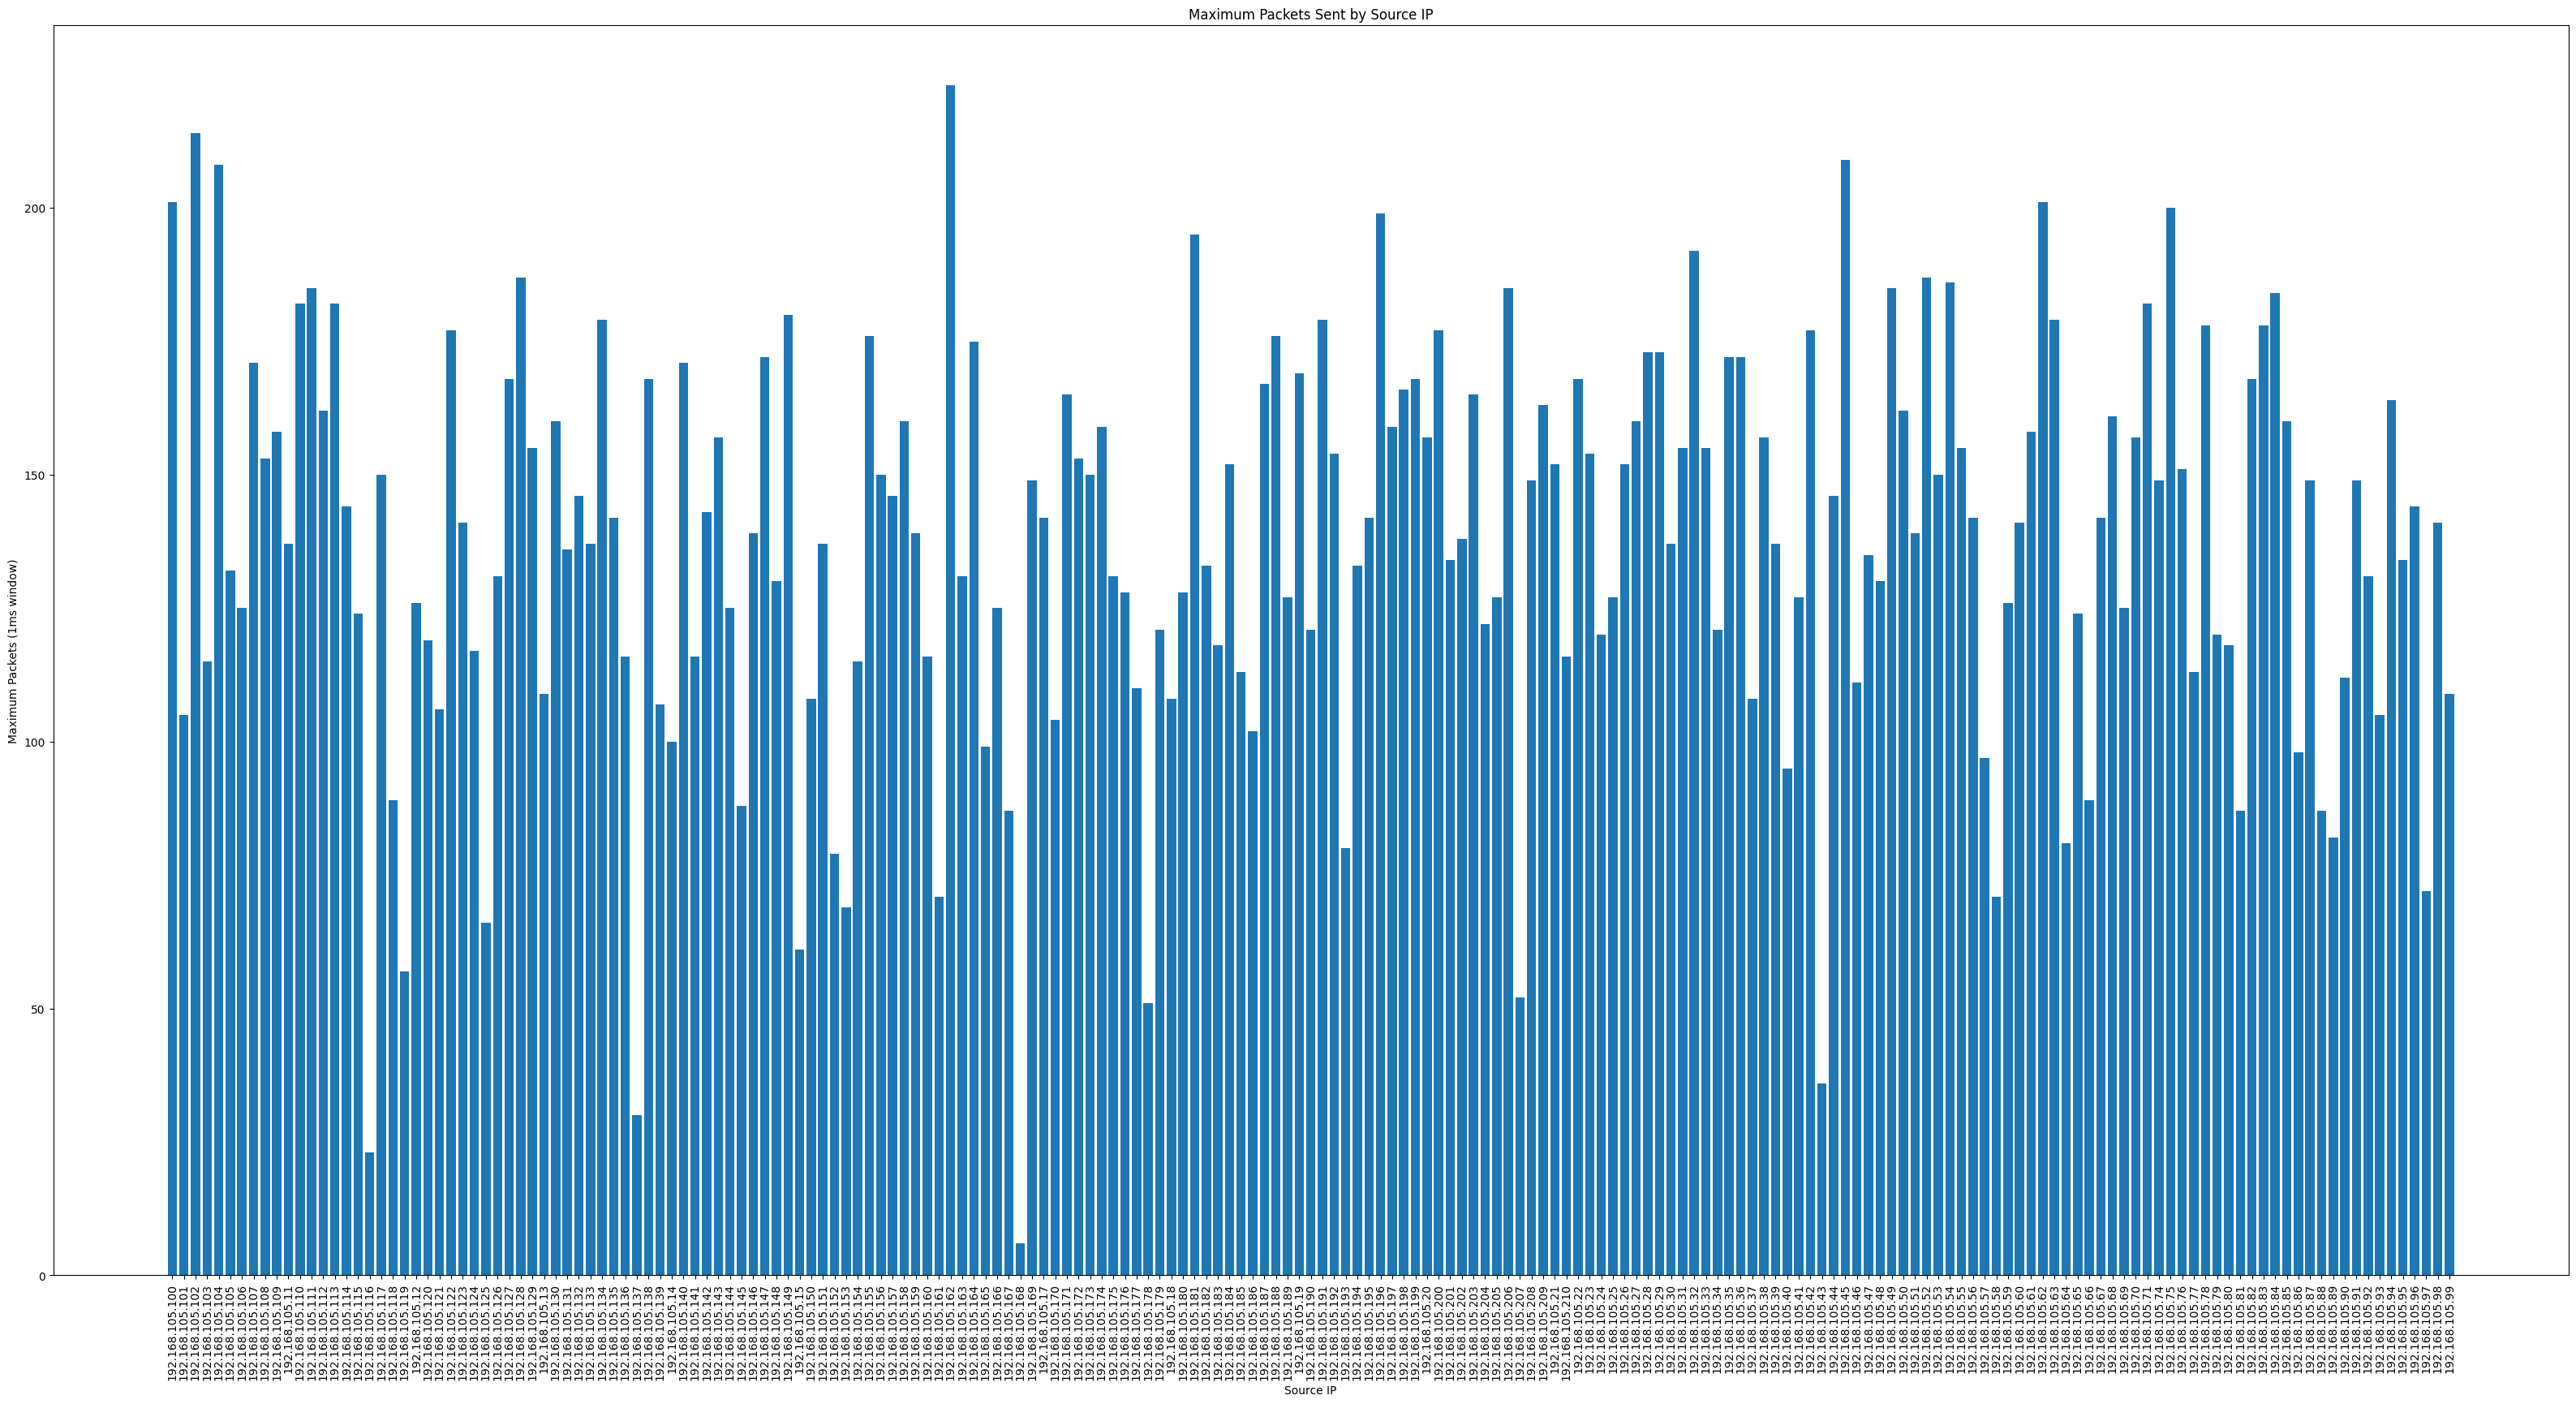

In [7]:
# Visualization

max_packets = packets_per_sec.groupby('src_ip')['packets'].max().reset_index()

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(40, 20))

# Create a bar graph of the maximum packets for each source IP
ax.bar(max_packets['src_ip'], max_packets['packets'], color='tab:blue')

# Set labels and title
ax.set_xlabel('Source IP')
ax.set_ylabel('Maximum Packets (1ms window)')
ax.set_title('Maximum Packets Sent by Source IP')

# Rotate x-axis tick labels for better visibility
ax.tick_params(axis='x', rotation=90)

# Show the graph
plt.show()

In [8]:
# Number of packets per milisecond, for each source/destination IP combination.

# Test Data
test=pd.read_parquet(testfile)

test['timestamp'] = pd.to_datetime(test['timestamp'])
test.set_index('timestamp', inplace=True)
grouped = test.groupby([pd.Grouper(freq='1ms'), 'src_ip', 'dst_ip'])
t_packets_per_sec = grouped.size().reset_index(name='packets').sort_values(by='packets',ascending=False)

print(t_packets_per_sec[:100].to_string())

                    timestamp           src_ip           dst_ip  packets
20339 1970-01-01 00:00:00.004  192.168.105.141  192.168.105.225     8063
20342 1970-01-01 00:00:00.004  192.168.105.141  192.168.105.238     7904
5222  1970-01-01 00:00:00.003  192.168.105.106  192.168.105.225     7750
5225  1970-01-01 00:00:00.003  192.168.105.106  192.168.105.238     7606
8021  1970-01-01 00:00:00.003  192.168.105.141  192.168.105.225     6268
8024  1970-01-01 00:00:00.003  192.168.105.141  192.168.105.238     6250
46178 1970-01-01 00:00:00.006  192.168.105.141  192.168.105.238     5625
34859 1970-01-01 00:00:00.005  192.168.105.141  192.168.105.238     5090
34858 1970-01-01 00:00:00.005  192.168.105.141  192.168.105.225     4684
46175 1970-01-01 00:00:00.006  192.168.105.141  192.168.105.225     4651
17360 1970-01-01 00:00:00.004  192.168.105.106  192.168.105.225     2027
17363 1970-01-01 00:00:00.004  192.168.105.106  192.168.105.238     1842
33981 1970-01-01 00:00:00.005  192.168.105.129  192

In [9]:
# Detection & Filtering
max_packets = packets_per_sec.groupby('src_ip')['packets'].max().reset_index()
t_max_packets = t_packets_per_sec.groupby('src_ip')['packets'].max().reset_index()


matching_combos = max_packets.merge(t_max_packets, on=['src_ip'])  
threshold = matching_combos['packets_x'] * 2
filtered = matching_combos[matching_combos['packets_y'] > threshold]
print(filtered.to_string())



              src_ip  packets_x  packets_y
6    192.168.105.106        125       7750
17   192.168.105.116         23        145
20   192.168.105.119         57        168
27   192.168.105.125         66        178
31   192.168.105.129        155        372
45   192.168.105.141        116       8063
53    192.168.105.15         61        132
57   192.168.105.153         69        179
65   192.168.105.161         71        148
72   192.168.105.168          6        102
117   192.168.105.21        152        324
140   192.168.105.43         36        182
191   192.168.105.97         72        179


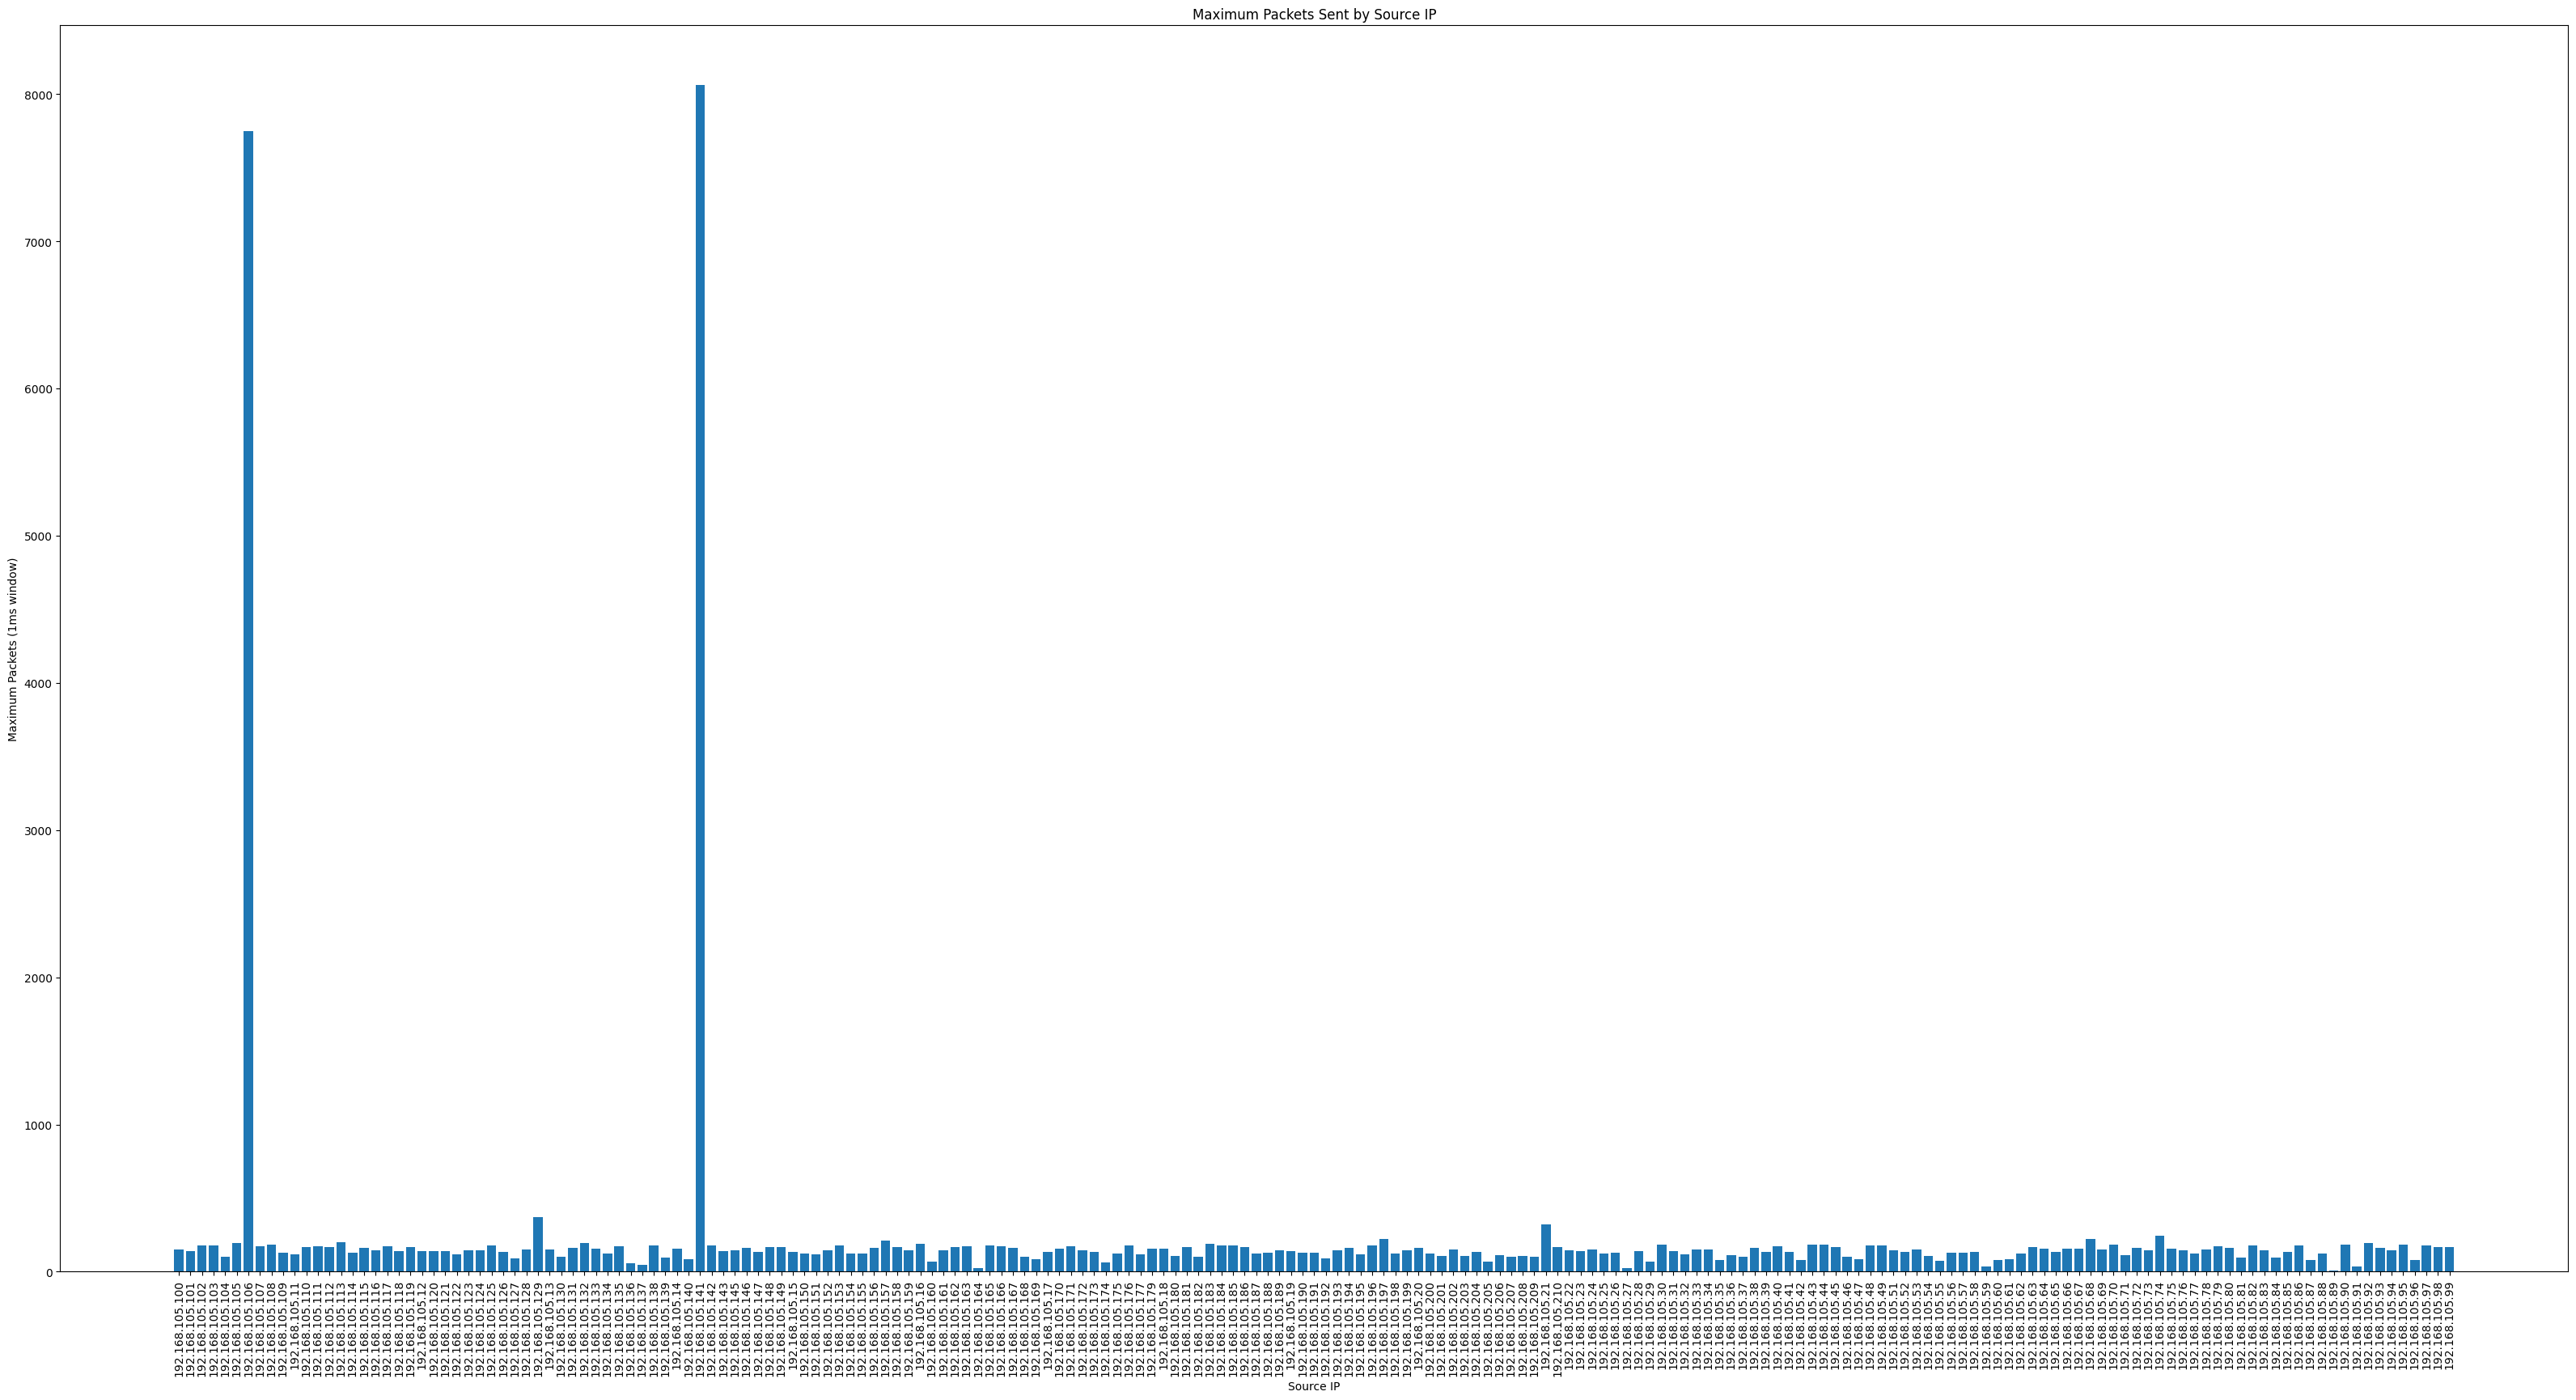

In [10]:
# Visualization for test data

max_packets = t_packets_per_sec.groupby('src_ip')['packets'].max().reset_index()

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(40, 20))

# Create a bar graph of the maximum packets for each source IP
ax.bar(max_packets['src_ip'], max_packets['packets'], color='tab:blue')

# Set labels and title
ax.set_xlabel('Source IP')
ax.set_ylabel('Maximum Packets (1ms window)')
ax.set_title('Maximum Packets Sent by Source IP')

# Rotate x-axis tick labels for better visibility
ax.tick_params(axis='x', rotation=90)

# Show the graph
plt.show()

In [11]:
# Destination IP addresses and frequency, for each source IP.. 
data=pd.read_parquet(datafile)
total_packets=len(data)
grouped = data.groupby(['src_ip','dst_ip'])['timestamp'].count().reset_index(name="packets")
grouped=grouped[['src_ip','dst_ip','packets']]
test=grouped['packets'].sum()
grouped['packets_percent'] = (grouped['packets'] / total_packets) * 100
print(grouped.sort_values(by='packets_percent',ascending=False)[:100].to_string())


                src_ip           dst_ip  packets  packets_percent
19760  192.168.105.206  192.168.105.225      872         0.089997
19680  192.168.105.206   142.250.200.68      850         0.087726
92     192.168.105.100   142.250.200.68      835         0.086178
19763  192.168.105.206  192.168.105.238      800         0.082566
14339  192.168.105.181    172.217.17.14      753         0.077715
29883   192.168.105.75  192.168.105.238      734         0.075754
19731  192.168.105.206    172.217.17.14      729         0.075238
29880   192.168.105.75  192.168.105.225      726         0.074928
18963  192.168.105.203    172.217.17.14      724         0.074722
19709  192.168.105.206   157.240.212.35      722         0.074516
18990  192.168.105.203  192.168.105.238      717         0.074000
149    192.168.105.100    172.217.17.14      715         0.073793
177    192.168.105.100  192.168.105.225      714         0.073690
14370  192.168.105.181  192.168.105.238      711         0.073380
18987  192

In [12]:
# Test
# Destination IP addresses and frequency, for each source IP.. 
test=pd.read_parquet(testfile)
t_total_packets=len(test)
t_grouped = test.groupby(['src_ip','dst_ip'])['timestamp'].count().reset_index(name="packets")
t_grouped=t_grouped[['src_ip','dst_ip','packets']]
test=t_grouped['packets'].sum()
t_grouped['packets_percent'] = (t_grouped['packets'] / t_total_packets) * 100
print(t_grouped.sort_values(by='packets_percent',ascending=False)[:100].to_string())



                src_ip           dst_ip  packets  packets_percent
8856   192.168.105.141  192.168.105.238    24869         2.419587
8853   192.168.105.141  192.168.105.225    23666         2.302543
1269   192.168.105.106  192.168.105.225     9777         0.951237
1272   192.168.105.106  192.168.105.238     9448         0.919227
6463   192.168.105.129  192.168.105.238     1190         0.115779
6460   192.168.105.129  192.168.105.225     1034         0.100601
7743   192.168.105.135   142.250.200.68      832         0.080948
33489   192.168.105.95  192.168.105.238      828         0.080559
20946   192.168.105.21  192.168.105.225      812         0.079002
33486   192.168.105.95  192.168.105.225      775         0.075402
7822   192.168.105.135  192.168.105.225      730         0.071024
33462   192.168.105.95    172.217.17.14      724         0.070440
7825   192.168.105.135  192.168.105.238      706         0.068689
33395   192.168.105.95   142.250.200.68      694         0.067522
23130   19

In [13]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
# analysis
matching_combos = grouped.merge(t_grouped, on=['src_ip', 'dst_ip'])  
variations_df = pd.DataFrame(columns=['src_ip', 'dst_ip', 'variation'])
for index, combo in matching_combos.iterrows():
    src_ip = combo['src_ip']
    dst_ip = combo['dst_ip']
    
    packets_percent_before = grouped.loc[(grouped['src_ip'] == src_ip) 
    & (grouped['dst_ip'] == dst_ip), 'packets_percent'].iloc[0]
    packets_percent_after = t_grouped.loc[(t_grouped['src_ip'] == src_ip) & 
    (t_grouped['dst_ip'] == dst_ip), 'packets_percent'].iloc[0]
    
    variation = packets_percent_after - packets_percent_before
    #print(f"Source IP: {src_ip}, Destination IP: {dst_ip}, Variation: {variation}")
    variations_df = variations_df.append({'src_ip': src_ip, 'dst_ip': dst_ip, 'variation': variation}, ignore_index=True)

print(variations_df)


               src_ip          dst_ip  variation
0     192.168.105.100    104.17.45.30  -0.002560
1     192.168.105.100   104.22.47.238   0.000014
2     192.168.105.100  104.244.42.193  -0.018856
3     192.168.105.100      104.26.3.6  -0.008115
4     192.168.105.100     104.26.9.83  -0.001359
...               ...             ...        ...
9066   192.168.105.99   62.28.254.215   0.001002
9067   192.168.105.99   66.254.114.41   0.003078
9068   192.168.105.99  88.157.217.145   0.007700
9069   192.168.105.99  88.157.217.146   0.001034
9070   192.168.105.99  88.157.217.148  -0.000121

[9071 rows x 3 columns]


In [15]:
print(len(variations_df))
print(variations_df.sort_values(by='variation',ascending=False)[:100].to_string())

9071
               src_ip           dst_ip  variation
2159  192.168.105.141  192.168.105.238   2.393269
2156  192.168.105.141  192.168.105.225   2.286133
326   192.168.105.106  192.168.105.225   0.928944
329   192.168.105.106  192.168.105.238   0.903746
1525  192.168.105.129  192.168.105.238   0.083269
5523   192.168.105.21  192.168.105.225   0.061147
1522  192.168.105.129  192.168.105.225   0.056325
8872   192.168.105.95  192.168.105.238   0.053003
1845  192.168.105.135   142.250.200.68   0.050502
1313  192.168.105.125  192.168.105.225   0.043197
7613   192.168.105.66  192.168.105.238   0.042298
7600   192.168.105.66   157.240.212.35   0.042248
1316  192.168.105.125  192.168.105.238   0.042212
8869   192.168.105.95  192.168.105.225   0.041963
6183   192.168.105.34  192.168.105.225   0.041340
7602   192.168.105.66    172.217.17.14   0.041334
1298  192.168.105.125   142.250.200.68   0.041328
8857   192.168.105.95    172.217.17.14   0.041026
1863  192.168.105.135  192.168.105.225   0.03

In [16]:
# Detection & Filtering

threshold=0.1
print(variations_df[variations_df['variation']>threshold])

               src_ip           dst_ip  variation
326   192.168.105.106  192.168.105.225   0.928944
329   192.168.105.106  192.168.105.238   0.903746
2156  192.168.105.141  192.168.105.225   2.286133
2159  192.168.105.141  192.168.105.238   2.393269


In [17]:
# Ignore
# Old attempt at 3d plot
''' src_ips = grouped['src_ip']
dst_ips = grouped['dst_ip']
packets = grouped['packets']

# Set the axes labels
ax.set_xlabel('Source IP')
ax.set_ylabel('Destination IP')
ax.set_zlabel('Packets')

xn = range(len(src_ips))
yn = range(len(dst_ips))

x,y = np.meshgrid(xn,yn)
z = packets

# Plot the 3D colormap graph
sc = ax.plot_trisurf(x, y, z,  cmap='cool' )

# Add a colorbar
cbar = fig.colorbar(sc)
cbar.set_label('Packets')

# Show the graph
plt.show() '''

# new attempt at plot, too much data cant read :(
''' #plotting the bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Create a list of unique source IPs for x-axis labels
src_ips = grouped['src_ip'].unique()

# Iterate over each source IP
for src_ip in src_ips:
    # Get the corresponding rows for the source IP
    subset = grouped[grouped['src_ip'] == src_ip]
    
    # Plot the destination IPs and the number of packets per combo
    ax.bar(subset['dst_ip'], subset['packets'], label=src_ip)

# Set labels and title
ax.set_xlabel('Destination IP')
ax.set_ylabel('Packets')
ax.set_title('Packets per Source IP and Destination IP Combo')

# Rotate x-axis tick labels for better visibility
ax.tick_params(axis='x', rotation=90)


# Show the graph
plt.show() '''

" #plotting the bar graph\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Create a list of unique source IPs for x-axis labels\nsrc_ips = grouped['src_ip'].unique()\n\n# Iterate over each source IP\nfor src_ip in src_ips:\n    # Get the corresponding rows for the source IP\n    subset = grouped[grouped['src_ip'] == src_ip]\n    \n    # Plot the destination IPs and the number of packets per combo\n    ax.bar(subset['dst_ip'], subset['packets'], label=src_ip)\n\n# Set labels and title\nax.set_xlabel('Destination IP')\nax.set_ylabel('Packets')\nax.set_title('Packets per Source IP and Destination IP Combo')\n\n# Rotate x-axis tick labels for better visibility\nax.tick_params(axis='x', rotation=90)\n\n\n# Show the graph\nplt.show() "

In [42]:
# Volume of data (Bytes) coming from each machine

data=pd.read_parquet(datafile)

grouped = data.groupby('src_ip')
total_volume = data['up_bytes'].sum() + data['down_bytes'].sum()

volume_per_machine = grouped[['up_bytes', 'down_bytes']].sum()

percentage_per_machine = (volume_per_machine / total_volume) * 100


#up_vol = data['up_bytes'].sum() 
#down_vol = data['down_bytes'].sum()

print("Total Volume of Data:", total_volume)
print("Volume of Data per Machine:")
print(volume_per_machine)
print("\nPercentage of Data per Machine:")
print(percentage_per_machine)

print("Integrity test")



Total Volume of Data: 99609938690
Volume of Data per Machine:
                  up_bytes  down_bytes
src_ip                                
192.168.105.100  121367563  1110984752
192.168.105.101   52724243   481635183
192.168.105.102   63662612   574736338
192.168.105.103   48623851   452207367
192.168.105.104   52250205   487287945
...                    ...         ...
192.168.105.95    51726211   463683506
192.168.105.96    49640783   469388779
192.168.105.97     7928157    81871788
192.168.105.98    57518870   554121576
192.168.105.99    19836405   175931795

[197 rows x 2 columns]

Percentage of Data per Machine:
                 up_bytes  down_bytes
src_ip                               
192.168.105.100  0.121843    1.115335
192.168.105.101  0.052931    0.483521
192.168.105.102  0.063912    0.576987
192.168.105.103  0.048814    0.453978
192.168.105.104  0.052455    0.489196
...                   ...         ...
192.168.105.95   0.051929    0.465499
192.168.105.96   0.049835    0.4

In [ ]:
# Test
# Volume of data (Bytes) coming from each machine

test=pd.read_parquet(testfile)

grouped = test.groupby('src_ip')
total_volume_t = test['up_bytes'].sum() + test['down_bytes'].sum()

volume_per_machine = grouped[['up_bytes', 'down_bytes']].sum()

percentage_per_machine_t = (volume_per_machine / total_volume) * 100


#up_vol = data['up_bytes'].sum() 
#down_vol = data['down_bytes'].sum()

print("Total Volume of Data:", total_volume)
print("Volume of Data per Machine:")
print(volume_per_machine)
print("\nPercentage of Data per Machine:")
print(percentage_per_machine_t)

print("Integrity test")



In [46]:

merged_vol = percentage_per_machine.merge(percentage_per_machine_t, on=['src_ip'], suffixes=['_d', '_t']).drop_duplicates()

merged_vol['up_bytes_variation'] = merged_vol['up_bytes_t'] - merged_vol['up_bytes_d']
merged_vol['down_bytes_variation'] = merged_vol['down_bytes_t'] - merged_vol['down_bytes_d']
merged_vol.dropna(inplace=True)
merged_vol=merged_vol[['up_bytes_variation','down_bytes_variation']]
print(merged_vol.sort_values(['up_bytes_variation'],ascending=False)[:30])
print(merged_vol.sort_values(['down_bytes_variation'],ascending=False)[:30])

print(merged_vol.sort_values(['up_bytes_variation'],ascending=True)[:30])
print(merged_vol.sort_values(['down_bytes_variation',],ascending=True)[:30])

# Detection & Filtering

threshold=1
print(merged_vol[merged_vol['up_bytes_variation']>threshold])
print(merged_vol[merged_vol['up_bytes_variation']<-threshold])

print(merged_vol[merged_vol['down_bytes_variation']>threshold])
print(merged_vol[merged_vol['down_bytes_variation']<-threshold])

                 up_bytes_variation  down_bytes_variation
src_ip                                                   
192.168.105.20             5.171601             -0.047975
192.168.105.188            1.692113             -0.505467
192.168.105.183            0.179811              0.463227
192.168.105.118            0.178077              0.408568
192.168.105.95             0.076676              0.746000
192.168.105.135            0.075159              0.689556
192.168.105.125            0.072024              0.661479
192.168.105.66             0.071495              0.634442
192.168.105.34             0.069684              0.630486
192.168.105.119            0.062201              0.578411
192.168.105.108            0.057067              0.514342
192.168.105.115            0.056876              0.545507
192.168.105.133            0.056846              0.505115
192.168.105.67             0.055615              0.521850
192.168.105.153            0.053228              0.495439
192.168.105.43

In [20]:
# Analyzing ports
# Total number of usages
ports = data['port'].value_counts()
total_packets_num = data.shape[0]
total_volume = data['up_bytes'].sum() + data['down_bytes'].sum()

print("Ports Used for Communications:")
print(ports)

# In percentages

ports_percent = (ports / total_packets_num) * 100

print("Ports Used for Communications (%):")
print(ports_percent)

# Any port that's not one of these two or a massively different % distribution
# will be suspicious


Ports Used for Communications:
443    853677
53     115248
Name: port, dtype: int64
Ports Used for Communications (%):
443    88.105581
53     11.894419
Name: port, dtype: float64


In [40]:
# Volume of data, by port.
volume_by_port = data.groupby('port')['up_bytes', 'down_bytes'].sum()

port_vol_percent = (volume_by_port / total_volume) * 100

print("Volume of Data by Port:")
print(volume_by_port)


print("Volume of Data by Port (%):")
print(port_vol_percent)

Volume of Data by Port:
        up_bytes   down_bytes
port                         
53      23076267     52898880
443   9727702861  89806260682
Volume of Data by Port (%):
      up_bytes  down_bytes
port                      
53    0.021855    0.050099
443   9.212774   85.052436


In [22]:
# Test
# Analyzing ports
# Total number of usages
ports = test['port'].value_counts()
total_packets_num = test.shape[0]
total_volume = test['up_bytes'].sum() + test['down_bytes'].sum()

print("Ports Used for Communications:")
print(ports)

# In percentages

ports_percent = (ports / total_packets_num) * 100

print("Ports Used for Communications (%):")
print(ports_percent)

# Any port that's not one of these two or a massively different % distribution
# will be suspicious


Ports Used for Communications:
443    845186
53     182634
Name: port, dtype: int64
Ports Used for Communications (%):
443    82.230935
53     17.769065
Name: port, dtype: float64


In [23]:
# Volume of data, by port.
volume_by_port = test.groupby('port')['up_bytes', 'down_bytes'].sum()

port_vol_percent = (volume_by_port / total_volume) * 100

print("Volume of Data by Port:")
print(volume_by_port)


print("Volume of Data by Port (%):")
print(port_vol_percent)

Volume of Data by Port:
         up_bytes   down_bytes
port                          
53       36576570     84087780
443   16797374743  88671248144
Volume of Data by Port (%):
       up_bytes  down_bytes
port                       
53     0.034640    0.079637
443   15.908219   83.977504


In [38]:
grouped = data.groupby(['src_ip', 'port'])
total_bytes = grouped['up_bytes', 'down_bytes'].sum()

percent_bytes = total_bytes.div(total_bytes.groupby('src_ip').transform('sum')) * 100

#print(percent_bytes)

grouped = test.groupby(['src_ip', 'port'])
total_bytes = grouped['up_bytes', 'down_bytes'].sum()

t_percent_bytes = total_bytes.div(total_bytes.groupby('src_ip').transform('sum')) * 100

#print(t_percent_bytes)

merged_ports = percent_bytes.merge(t_percent_bytes, on=['src_ip', 'port'], suffixes=['_d', '_t']).drop_duplicates()

merged_ports['up_bytes_variation'] = merged_ports['up_bytes_t'] - merged_ports['up_bytes_d']
merged_ports['down_bytes_variation'] = merged_ports['down_bytes_t'] - merged_ports['down_bytes_d']
merged_ports.dropna(inplace=True)
merged_ports=merged_ports[['up_bytes_variation','down_bytes_variation']]
print(merged_ports.sort_values(['up_bytes_variation','down_bytes_variation'],ascending=False)[:30])

print(merged_ports.sort_values(['up_bytes_variation','down_bytes_variation'],ascending=True)[:30])
# Detection & Filtering

threshold=1
print(merged_ports[merged_ports['up_bytes_variation']>threshold])
print(merged_ports[merged_ports['down_bytes_variation']>threshold])

                      up_bytes_variation  down_bytes_variation
src_ip          port                                          
192.168.105.141 53             22.839858              6.818845
192.168.105.106 53             10.747322              2.847368
192.168.105.168 443             1.186653              0.258434
192.168.105.21  53              0.852324              0.201611
192.168.105.89  443             0.271583              0.067218
192.168.105.129 53              0.269499              0.066226
192.168.105.188 443             0.247848              0.009944
192.168.105.20  443             0.236574              0.006924
192.168.105.164 53              0.198914              0.030140
192.168.105.118 443             0.167755              0.002987
192.168.105.182 443             0.145731              0.011068
192.168.105.183 443             0.145504              0.000636
192.168.105.91  53              0.079763              0.019994
192.168.105.92  53              0.073666              0

In [48]:
#Protocol used for communication.

# Total number of usages
proto = data['proto'].value_counts()
total_packets_proto = data.shape[0]

print("Protocol Used for Communications:")
print(proto)

# In percentages

proto_percent = (proto / total_packets_proto) * 100

print("Protocol Used for Communications (%):")
print(proto_percent)



Protocol Used for Communications:
tcp    851395
udp    117530
Name: proto, dtype: int64
Protocol Used for Communications (%):
tcp    87.870062
udp    12.129938
Name: proto, dtype: float64


In [47]:
# Test
#Protocol used for communication.

# Total number of usages
proto = test['proto'].value_counts()
total_packets_proto = test.shape[0]

print("Protocol Used for Communications:")
print(proto)

# In percentages

proto_percent_t = (proto / total_packets_proto) * 100

print("Protocol Used for Communications (%):")
print(proto_percent_t)



Protocol Used for Communications:
tcp    842895
udp    184925
Name: proto, dtype: int64
Protocol Used for Communications (%):
tcp    82.008036
udp    17.991964
Name: proto, dtype: float64


In [62]:
# Variation Proto Analysis
grouped = data.groupby(['src_ip', 'proto'])
total_bytes = grouped['up_bytes', 'down_bytes'].sum()

percent_bytes = total_bytes.div(total_bytes.groupby('src_ip').transform('sum')) * 100

#print(percent_bytes)

grouped = test.groupby(['src_ip', 'proto'])
total_bytes = grouped['up_bytes', 'down_bytes'].sum()

t_percent_bytes = total_bytes.div(total_bytes.groupby('src_ip').transform('sum')) * 100

#print(t_percent_bytes)

merged_proto = percent_bytes.merge(t_percent_bytes, on=['src_ip', 'proto'], suffixes=['_d', '_t']).drop_duplicates()
merged_proto['up_bytes_variation'] = merged_proto['up_bytes_t'] - merged_proto['up_bytes_d']
merged_proto['down_bytes_variation'] = merged_proto['down_bytes_t'] - merged_proto['down_bytes_d']
merged_proto.dropna(inplace=True)
merged_proto=merged_proto[['up_bytes_variation','down_bytes_variation']]
print(merged_proto.sort_values(['down_bytes_variation'],ascending=False)[:30])
print(merged_proto.sort_values(['up_bytes_variation'],ascending=False)[:30])

# Detection & Filtering

threshold=7
print(merged_proto[merged_proto['up_bytes_variation']>threshold])
print(merged_proto[merged_proto['down_bytes_variation']>threshold].to_string())

                       up_bytes_variation  down_bytes_variation
src_ip          proto                                          
192.168.105.164 udp              2.134167             11.628416
192.168.105.40  tcp              1.012022              8.185145
192.168.105.168 udp             -0.264823              7.498026
192.168.105.165 tcp              0.776530              7.145632
192.168.105.81  tcp              0.728540              6.830527
192.168.105.97  tcp              0.715462              6.678861
192.168.105.59  tcp              0.822587              6.647362
192.168.105.153 udp              0.630451              6.189669
192.168.105.93  udp              0.706733              5.881039
192.168.105.57  udp              0.700359              5.728980
192.168.105.185 udp              0.594755              5.626358
192.168.105.41  tcp              0.669780              5.499036
192.168.105.35  tcp              0.564264              4.390558
192.168.105.141 udp             22.42707

In [62]:
# DNS Name Resolution

# Get list with unique destination IP addresses
dst_ips=[i for i in data['dst_ip'].unique()]
# print(len(dst_addrs))
resolved_ips=[]
failed_ips=[]
# Resolve these addresses via DNS
for ip in dst_ips[:100]:
  try:
    name=dns.reversename.from_address(ip)
    addr=dns.resolver.resolve(name, 'PTR')
    for a in addr:
      resolved_ips.append((ip,a))
  except:
    failed_ips.append(ip)

print(resolved_ips)
print(failed_ips)



[('157.240.212.35', <DNS IN PTR rdata: edge-star-mini-shv-01-lis1.facebook.com.>), ('88.157.217.145', <DNS IN PTR rdata: a88-157-217-145.static.cpe.netcabo.pt.>), ('185.15.58.224', <DNS IN PTR rdata: text-lb.drmrs.wikimedia.org.>), ('157.240.212.174', <DNS IN PTR rdata: instagram-p42-shv-01-lis1.fbcdn.net.>), ('173.255.218.143', <DNS IN PTR rdata: 173-255-218-143.ip.linodeusercontent.com.>), ('142.250.200.68', <DNS IN PTR rdata: mad07s24-in-f4.1e100.net.>), ('148.69.168.40', <DNS IN PTR rdata: 40.168.69.148.rev.vodafone.pt.>), ('172.217.17.14', <DNS IN PTR rdata: mad07s09-in-f14.1e100.net.>), ('18.154.48.124', <DNS IN PTR rdata: server-18-154-48-124.mad56.r.cloudfront.net.>), ('193.126.240.146', <DNS IN PTR rdata: websites.iolnegocios.com.>), ('23.49.244.192', <DNS IN PTR rdata: a23-49-244-192.deploy.static.akamaitechnologies.com.>), ('66.254.114.41', <DNS IN PTR rdata: reflectededge.reflected.net.>), ('54.192.95.95', <DNS IN PTR rdata: server-54-192-95-95.mad51.r.cloudfront.net.>), ('

In [105]:
print(len(resolved_ips))

resolved_tlds = [tldextract.extract(domain.to_text()).suffix for _, domain in resolved_ips]
resolved_ipA=[domain.to_text() for _,domain in resolved_ips]
resolved_tlds,counts=np.unique(resolved_tlds, return_counts=True)
tlds = []
for value, count in zip(resolved_tlds, counts):
    tlds.append((value,count))

print(tlds)
print(resolved_ipA)

32
[('com', 9), ('net', 15), ('org', 1), ('pt', 7)]
['mad07s24-in-f4.1e100.net.', 'text-lb.drmrs.wikimedia.org.', 'sapo.pt.', 'a88-157-217-145.static.cpe.netcabo.pt.', 'mad41s04-in-f3.1e100.net.', 'websites.iolnegocios.com.', 'www.abola.pt.', 'a-0010.a-msedge.net.', 'mad07s09-in-f14.1e100.net.', 'edge-star-mini-shv-01-lis1.facebook.com.', 'whatsapp-cdn-shv-01-lis1.fbcdn.net.', 'instagram-p42-shv-01-lis1.fbcdn.net.', 'lb1-c114-pub.pressidium.com.', 'www.meteo.pt.', 'a23-49-244-54.deploy.static.akamaitechnologies.com.', 'server-54-192-95-95.mad51.r.cloudfront.net.', 'a88-157-217-148.static.cpe.netcabo.pt.', '40.168.69.148.rev.vodafone.pt.', 'cdn1.xcloudserver.com.', 'server-18-154-48-124.mad56.r.cloudfront.net.', 'a88-157-217-146.static.cpe.netcabo.pt.', 'reflectededge.reflected.net.', 'server-108-157-98-113.mad56.r.cloudfront.net.', 'mad07s23-in-f21.1e100.net.', 'parkingpage.namecheap.com.', 'server-18-154-22-25.mad53.r.cloudfront.net.', 'node-ca1.wormly.com.', 'mad07s23-in-f17.1e100.ne

In [64]:
# geolocalization of dst_ips


### IP geolocalization
gi=pygeoip.GeoIP('drive/MyDrive/GeoIP.dat')
gi2=pygeoip.GeoIP('drive/MyDrive/GeoIPASNum.dat')



NET=ipaddress.IPv4Network('192.168.105.0/24')
bpublic=data.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1)

cc=data[bpublic]['dst_ip'].apply(lambda y:gi.country_code_by_addr(y)).to_frame(name='cc')

In [65]:
geo_count=cc.value_counts()
total_num = data.shape[0]
print(geo_count)
geo_pc=(geo_count/total_num) * 100
print(geo_pc)

cc
US    345497
PT    287299
NL     18338
NA     13209
GB      8171
BR      5615
ES      2087
IE      1231
IN       551
DE       471
JP       370
SG       341
IT       261
CA       244
AU       228
FR       225
SE       221
KR       178
HK       175
CN       143
ZA        96
IL        87
CH        87
BH        80
AE        59
SA        46
NO        45
ID        41
MY        26
TW        23
BE        23
AP        22
CL        14
PL         9
DK         1
dtype: int64
cc
US    35.657765
PT    29.651315
NL     1.892613
NA     1.363263
GB     0.843306
BR     0.579508
ES     0.215393
IE     0.127048
IN     0.056867
DE     0.048611
JP     0.038187
SG     0.035194
IT     0.026937
CA     0.025183
AU     0.023531
FR     0.023222
SE     0.022809
KR     0.018371
HK     0.018061
CN     0.014759
ZA     0.009908
IL     0.008979
CH     0.008979
BH     0.008257
AE     0.006089
SA     0.004748
NO     0.004644
ID     0.004231
MY     0.002683
TW     0.002374
BE     0.002374
AP     0.002271
CL     0.00144

In [66]:
# Test
# DNS Name Resolution

# Get list with unique destination IP addresses
dst_ips=[i for i in test['dst_ip'].unique()]
# print(len(dst_addrs))
resolved_ips=[]
failed_ips=[]
# Resolve these addresses via DNS
for ip in dst_ips[:100]:
  try:
    name=dns.reversename.from_address(ip)
    addr=dns.resolver.resolve(name, 'PTR')
    for a in addr:
      resolved_ips.append((ip,a))
  except:
    failed_ips.append(ip)

print(resolved_ips)
print(failed_ips)



[('142.250.200.68', <DNS IN PTR rdata: mad07s24-in-f4.1e100.net.>), ('185.15.58.224', <DNS IN PTR rdata: text-lb.drmrs.wikimedia.org.>), ('213.13.146.142', <DNS IN PTR rdata: sapo.pt.>), ('88.157.217.145', <DNS IN PTR rdata: a88-157-217-145.static.cpe.netcabo.pt.>), ('216.58.215.131', <DNS IN PTR rdata: mad41s04-in-f3.1e100.net.>), ('193.126.240.146', <DNS IN PTR rdata: websites.iolnegocios.com.>), ('193.126.232.45', <DNS IN PTR rdata: www.abola.pt.>), ('204.79.197.212', <DNS IN PTR rdata: a-0010.a-msedge.net.>), ('172.217.17.14', <DNS IN PTR rdata: mad07s09-in-f14.1e100.net.>), ('157.240.212.35', <DNS IN PTR rdata: edge-star-mini-shv-01-lis1.facebook.com.>), ('157.240.212.60', <DNS IN PTR rdata: whatsapp-cdn-shv-01-lis1.fbcdn.net.>), ('157.240.212.174', <DNS IN PTR rdata: instagram-p42-shv-01-lis1.fbcdn.net.>), ('97.107.142.6', <DNS IN PTR rdata: lb1-c114-pub.pressidium.com.>), ('193.137.20.123', <DNS IN PTR rdata: www.meteo.pt.>), ('23.49.244.54', <DNS IN PTR rdata: a23-49-244-54.dep

In [67]:
print(len(resolved_ips))

resolved_tlds = [tldextract.extract(domain.to_text()).suffix for _, domain in resolved_ips]
resolved_ipA=[domain.to_text() for _,domain in resolved_ips]
resolved_tlds,counts=np.unique(resolved_tlds, return_counts=True)
tlds = []
for value, count in zip(resolved_tlds, counts):
    tlds.append((value,count))

print(tlds)
print(resolved_ipA)

32
[('com', 9), ('net', 15), ('org', 1), ('pt', 7)]
['mad07s24-in-f4.1e100.net.', 'text-lb.drmrs.wikimedia.org.', 'sapo.pt.', 'a88-157-217-145.static.cpe.netcabo.pt.', 'mad41s04-in-f3.1e100.net.', 'websites.iolnegocios.com.', 'www.abola.pt.', 'a-0010.a-msedge.net.', 'mad07s09-in-f14.1e100.net.', 'edge-star-mini-shv-01-lis1.facebook.com.', 'whatsapp-cdn-shv-01-lis1.fbcdn.net.', 'instagram-p42-shv-01-lis1.fbcdn.net.', 'lb1-c114-pub.pressidium.com.', 'www.meteo.pt.', 'a23-49-244-54.deploy.static.akamaitechnologies.com.', 'server-54-192-95-95.mad51.r.cloudfront.net.', 'a88-157-217-148.static.cpe.netcabo.pt.', '40.168.69.148.rev.vodafone.pt.', 'cdn1.xcloudserver.com.', 'server-18-154-48-124.mad56.r.cloudfront.net.', 'a88-157-217-146.static.cpe.netcabo.pt.', 'reflectededge.reflected.net.', 'server-108-157-98-113.mad56.r.cloudfront.net.', 'mad07s23-in-f21.1e100.net.', 'parkingpage.namecheap.com.', 'server-18-154-22-25.mad53.r.cloudfront.net.', 'node-ca1.wormly.com.', 'mad07s23-in-f17.1e100.ne

In [63]:
#Test

# Geolocation of dst_ips


### IP geolocalization
gi=pygeoip.GeoIP('drive/MyDrive/GeoIP.dat')
gi2=pygeoip.GeoIP('drive/MyDrive/GeoIPASNum.dat')



NET=ipaddress.IPv4Network('192.168.105.0/24')
bpublic=test.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1)

cc=test[bpublic]['dst_ip'].apply(lambda y:gi.country_code_by_addr(y)).to_frame(name='cc')


KeyboardInterrupt: ignored

In [ ]:
geo_count=cc.value_counts()
total_num = test.shape[0]
print(geo_count)
t_geo_pc=(geo_count/total_num) * 100
print(t_geo_pc)

In [70]:
# Countries in test data that weren't in original data

new_countries_step1 = t_geo_pc.index.difference(geo_pc.index)
new_countries = t_geo_pc.loc[new_countries_step1]
[i[0] for i in new_countries.index.tolist() if i[0]!='']

['AR',
 'AT',
 'BA',
 'BY',
 'EE',
 'FI',
 'GE',
 'KG',
 'KH',
 'KZ',
 'LB',
 'LU',
 'MM',
 'NZ',
 'OM',
 'RU',
 'SC',
 'TH',
 'UA',
 'UZ']

In [71]:
comp=pd.DataFrame(columns=['country','variation','is_new'])
for country in t_geo_pc.index:
  if country[0]=='':
    continue
  if country in geo_pc:
    country=country[0]
    dif=t_geo_pc[country] - geo_pc[country]
    comp=comp.append({'country':country,'variation':dif,'is_new':False},ignore_index=True)
  else:
    country=country[0]
    comp=comp.append({'country':country,'variation':t_geo_pc[country],'is_new':True},ignore_index=True)

print(comp.sort_values(by=['is_new','variation'],ascending=False))

   country  variation is_new
8       RU   0.076473   True
31      KG   0.001654   True
32      UA   0.001557   True
33      MM   0.001557   True
35      LB   0.001265   True
37      BY   0.000486   True
39      FI   0.000389   True
40      LU   0.000389   True
41      KH   0.000389   True
42      OM   0.000292   True
43      GE   0.000292   True
44      BA   0.000292   True
45      AT   0.000292   True
46      UZ   0.000292   True
47      SC   0.000292   True
48      TH   0.000195   True
49      EE   0.000097   True
50      NZ   0.000097   True
51      KZ   0.000097   True
52      AR   0.000097   True
9       CN   0.036807  False
12      AU   0.012370  False
15      HK   0.011029  False
21      ZA   0.003519  False
22      CH   0.003377  False
25      MY   0.001889  False
29      CL   0.000793  False
34      PL   0.000433  False
24      NO   0.000123  False
10      JP  -0.000048  False
36      BE  -0.001498  False
28      ID  -0.001507  False
27      AE  -0.001614  False
38      TW  -0

In [90]:
sus_geo=['RU']


gi=pygeoip.GeoIP('drive/MyDrive/GeoIP.dat')
gi2=pygeoip.GeoIP('drive/MyDrive/GeoIPASNum.dat')



NET=ipaddress.IPv4Network('192.168.105.0/24')
#bpublic=test.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1)


In [91]:

sus_ips=[]
for index, row in test.iterrows():
    if ipaddress.IPv4Address(row['dst_ip']) not in NET:
        country = gi.country_code_by_addr(row['dst_ip'])
        if country in sus_geo:
            sus_ips.append((row['src_ip']))
#a= test[bpublic]['dst_ip'].apply(lambda y:gi.country_code_by_addr(y))


In [92]:
print(set(sus_ips))

{'192.168.105.76', '192.168.105.159'}


In [ ]:
# Is source ip and dest ip an internal ip? (Red Flag)

NET=ipaddress.IPv4Network('192.168.105.0/24')
internal_comms=data.apply(lambda x: ipaddress.IPv4Address(x['src_ip'])  in NET and ipaddress.IPv4Address(x['dst_ip'])  in NET,axis=1)

internal_comms = data[internal_comms]

# internal_comms = pd.DataFrame({'Source IP': data['src_ip'], 'Destination IP': data['dst_ip'], 'Both IPs in Network': internal_comms})
print(internal_comms)





In [ ]:
print(internal_comms.groupby(['src_ip','dst_ip']).size())

In [ ]:
# Test
# Is source ip and dest ip an internal ip? (Red Flag)

NET=ipaddress.IPv4Network('192.168.105.0/24')
t_internal_comms=test.apply(lambda x: ipaddress.IPv4Address(x['src_ip'])  in NET and ipaddress.IPv4Address(x['dst_ip'])  in NET,axis=1)

t_internal_comms = test[t_internal_comms]

# internal_comms = pd.DataFrame({'Source IP': data['src_ip'], 'Destination IP': data['dst_ip'], 'Both IPs in Network': internal_comms})
print(t_internal_comms)





In [ ]:
print(t_internal_comms.groupby(['src_ip','dst_ip']).size())